In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff

In [2]:
plt.style.use('ggplot')


SEED = 0
np.random.seed(SEED)

TARGET = "SalePrice"
TRAIN_SET = "train.csv"
TEST_SET = 'test.csv'

TIME_VARIATIONS = ['year', 'yr']

In [3]:
df_train = pd.read_csv(TRAIN_SET)
df_test = pd.read_csv(TEST_SET)
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## First Intuition

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
numerical_variables = [var for var in df_train.columns if df_train[var].dtypes != 'O']
numerical_variables.pop(numerical_variables.index(TARGET))
numerical_variables_num = len(numerical_variables)
print('Number of numerical variables: ', numerical_variables_num)
for var in numerical_variables:
    print(var, end=' - ')

Number of numerical variables:  37
Id - MSSubClass - LotFrontage - LotArea - OverallQual - OverallCond - YearBuilt - YearRemodAdd - MasVnrArea - BsmtFinSF1 - BsmtFinSF2 - BsmtUnfSF - TotalBsmtSF - 1stFlrSF - 2ndFlrSF - LowQualFinSF - GrLivArea - BsmtFullBath - BsmtHalfBath - FullBath - HalfBath - BedroomAbvGr - KitchenAbvGr - TotRmsAbvGrd - Fireplaces - GarageYrBlt - GarageCars - GarageArea - WoodDeckSF - OpenPorchSF - EnclosedPorch - 3SsnPorch - ScreenPorch - PoolArea - MiscVal - MoSold - YrSold - 

In [6]:
time_vars = [var for var in numerical_variables for var2 in TIME_VARIATIONS if var2 in var.lower()]
print('Number of time variables: ', len(time_vars))
for var in time_vars:
    print(var, end=' - ')

Number of time variables:  4
YearBuilt - YearRemodAdd - GarageYrBlt - YrSold - 

In [7]:
discrete_vars = [var for var in numerical_variables if len(df_train[var].unique()) < 20 and var not in time_vars]
discrete_vars_num = len(discrete_vars)
print('Number of discrete variables: ', discrete_vars_num)
for var in discrete_vars:
    print(var, end=' - ')

Number of discrete variables:  14
MSSubClass - OverallQual - OverallCond - BsmtFullBath - BsmtHalfBath - FullBath - HalfBath - BedroomAbvGr - KitchenAbvGr - TotRmsAbvGrd - Fireplaces - GarageCars - PoolArea - MoSold - 

In [8]:
# removing 'PoolArea' since its a continuous variable even if it has few values
discrete_vars.pop(discrete_vars.index("PoolArea"));
discrete_vars_num -= 1

In [9]:
continuous_vars = [var for var in numerical_variables if var not in time_vars+discrete_vars]
print('Number of continuous variables: ', len(continuous_vars))
for var in continuous_vars:
    print(var, end=' - ')

Number of continuous variables:  20
Id - LotFrontage - LotArea - MasVnrArea - BsmtFinSF1 - BsmtFinSF2 - BsmtUnfSF - TotalBsmtSF - 1stFlrSF - 2ndFlrSF - LowQualFinSF - GrLivArea - GarageArea - WoodDeckSF - OpenPorchSF - EnclosedPorch - 3SsnPorch - ScreenPorch - PoolArea - MiscVal - 

In [10]:
categorical_variables = [var for var in df_train.columns if df_train[var].dtypes == 'O']
categorical_variables_num = len(categorical_variables)
print('Number of categorical variables: ', categorical_variables_num)
for var in categorical_variables:
    print(var, end=' - ')

Number of categorical variables:  43
MSZoning - Street - Alley - LotShape - LandContour - Utilities - LotConfig - LandSlope - Neighborhood - Condition1 - Condition2 - BldgType - HouseStyle - RoofStyle - RoofMatl - Exterior1st - Exterior2nd - MasVnrType - ExterQual - ExterCond - Foundation - BsmtQual - BsmtCond - BsmtExposure - BsmtFinType1 - BsmtFinType2 - Heating - HeatingQC - CentralAir - Electrical - KitchenQual - Functional - FireplaceQu - GarageType - GarageFinish - GarageQual - GarageCond - PavedDrive - PoolQC - Fence - MiscFeature - SaleType - SaleCondition - 

In [11]:
print("Number of complete duplicates: ", df_train.duplicated().sum())

Number of complete duplicates:  0


In [12]:
print(f"Number of nulls in features: {df_train.isnull().sum().sum()}")

Number of nulls in features: 6965


In [13]:
null_variables_in_numerics = [var for var in numerical_variables if df_train[var].isnull().sum() > 0]
print(f"Number of nulls in numerical features: {df_train[null_variables_in_numerics].isnull().sum().sum()}")
num_nulls = df_train.isnull().mean()
num_nulls.sort_values(ascending=False).head(numerical_variables_num)

Number of nulls in numerical features: 348


PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageCond      0.055479
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
Utilities       0.000000
YearRemodAdd    0.000000
MSSubClass      0.000000
Foundation      0.000000
ExterCond       0.000000
ExterQual       0.000000
Exterior2nd     0.000000
Exterior1st     0.000000
RoofMatl        0.000000
RoofStyle       0.000000
YearBuilt       0.000000
LotConfig       0.000000
OverallCond     0.000000
OverallQual     0.000000
HouseStyle      0.000000
BldgType        0.000000
Condition2      0.000000
BsmtFinSF1      0.000000
dtype: float64

In [14]:
null_variables_in_categoric = [var for var in categorical_variables if df_train[var].isnull().sum() > 0]
print(f"Number of nulls in categorical features: {df_train[null_variables_in_categoric].isnull().sum().sum()}")
num_nulls = df_train.isnull().mean()
num_nulls.sort_values(ascending=False).head(categorical_variables_num)

Number of nulls in categorical features: 6617


PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageCond      0.055479
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
Utilities       0.000000
YearRemodAdd    0.000000
MSSubClass      0.000000
Foundation      0.000000
ExterCond       0.000000
ExterQual       0.000000
Exterior2nd     0.000000
Exterior1st     0.000000
RoofMatl        0.000000
RoofStyle       0.000000
YearBuilt       0.000000
LotConfig       0.000000
OverallCond     0.000000
OverallQual     0.000000
HouseStyle      0.000000
BldgType        0.000000
Condition2      0.000000
BsmtFinSF1      0.000000
MSZoning        0.000000
LotArea         0.000000
Street          0.000000


### First Intuition Summary
* 1460 records. 
* 80 feature + target.
* 37 numerical feature include (4 time features + target).
* 43 categorical features.
* 0 complete duplicates.
* 6965 null value in all features.
* 348 nulls in numerical features.
* 6617 nulls in categorical features.

## Target vs All

In [15]:
df_train[TARGET].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

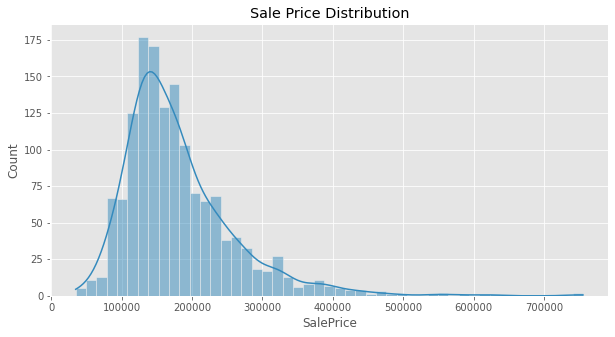

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(df_train[TARGET], kde=True)
plt.title("Sale Price Distribution");

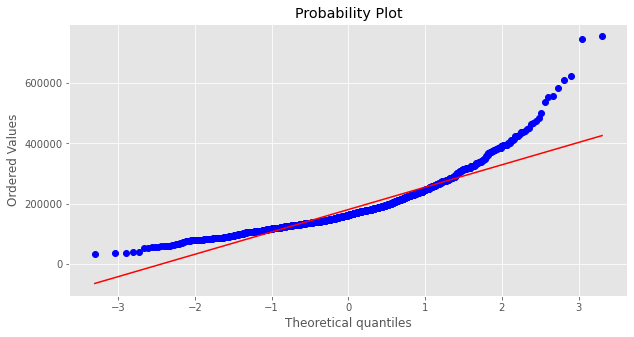

In [17]:
plt.figure(figsize=(10, 5))
stats.probplot(df_train[TARGET], plot=plt);

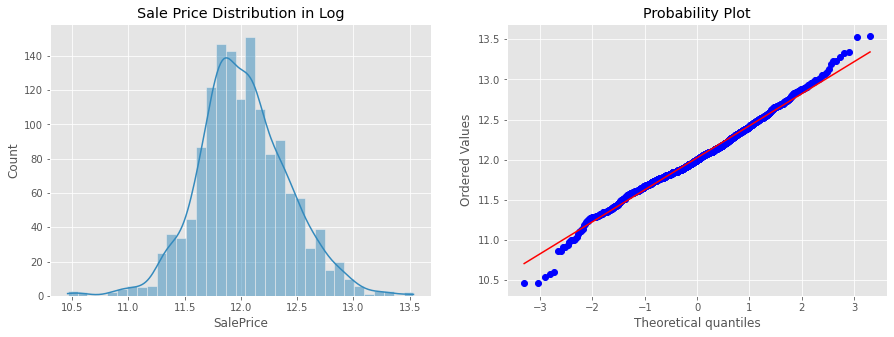

In [18]:
sale_price_log_transformed = np.log(df_train[TARGET])
plt.figure(figsize=(15, 5))

plt.subplot(1 , 2, 1)
sns.histplot(sale_price_log_transformed, kde=True)
plt.title("Sale Price Distribution in Log");

plt.subplot(1 , 2, 2)
stats.probplot(sale_price_log_transformed, plot=plt);

In [19]:
# df_train[TARGET] = np.log(df_train[TARGET])

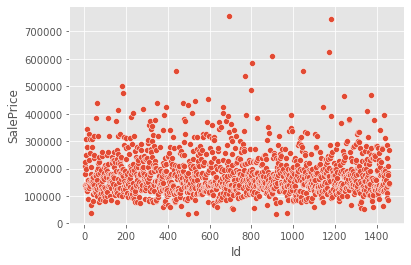

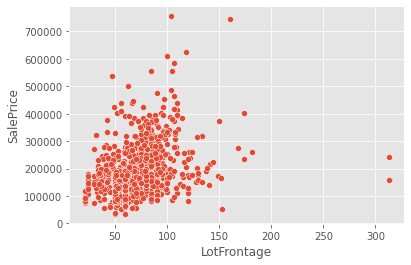

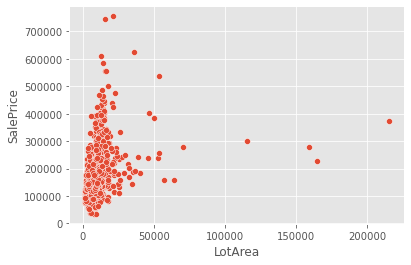

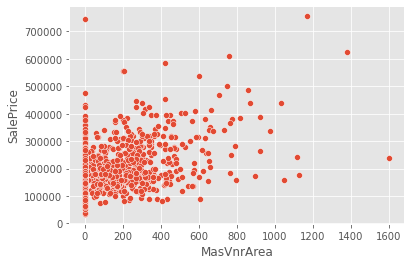

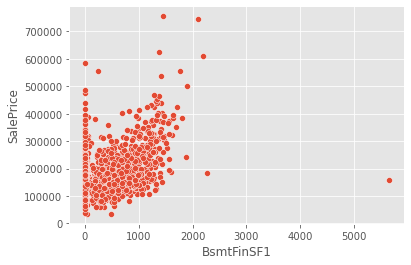

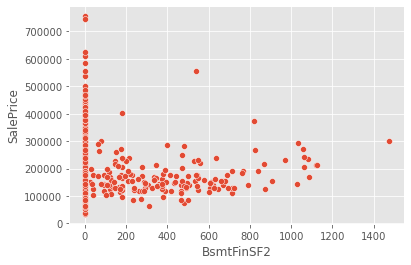

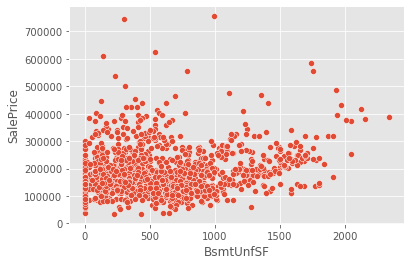

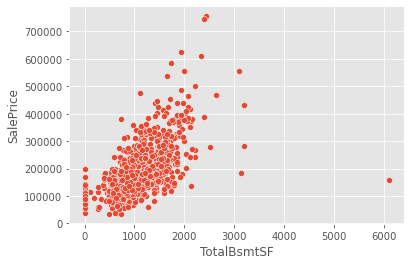

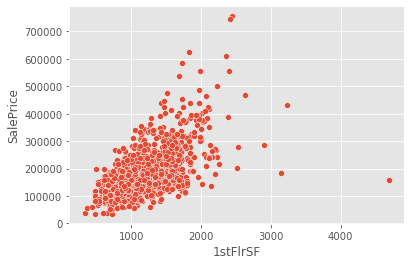

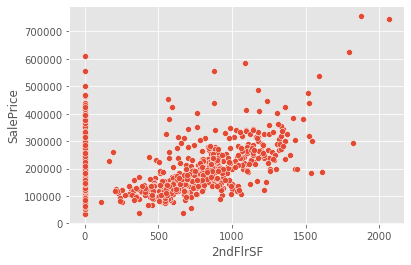

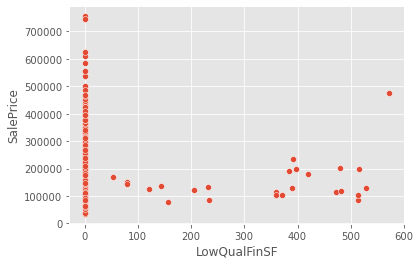

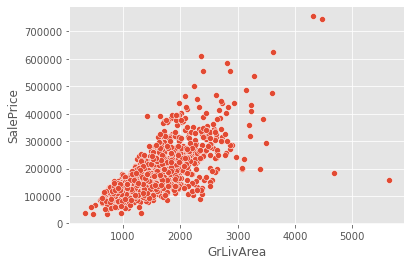

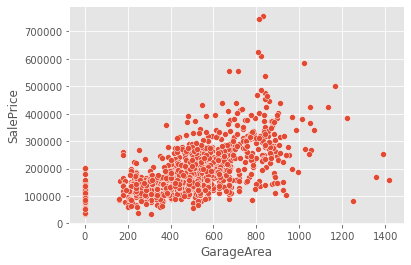

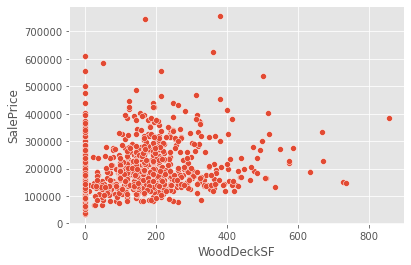

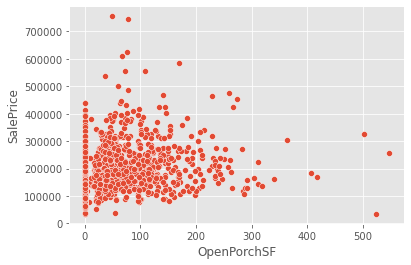

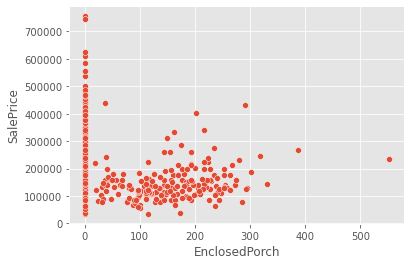

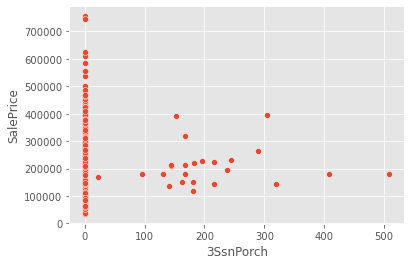

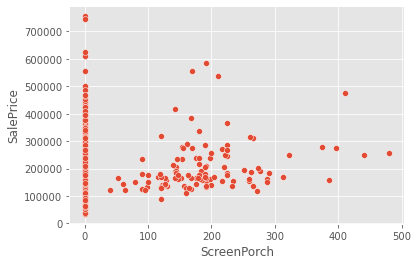

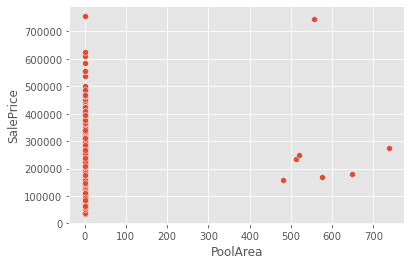

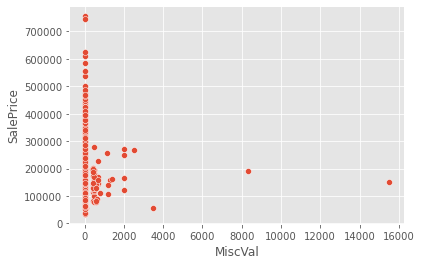

In [20]:
for var in continuous_vars:
    sns.scatterplot(data=df_train, x=var, y=TARGET)
    plt.show();

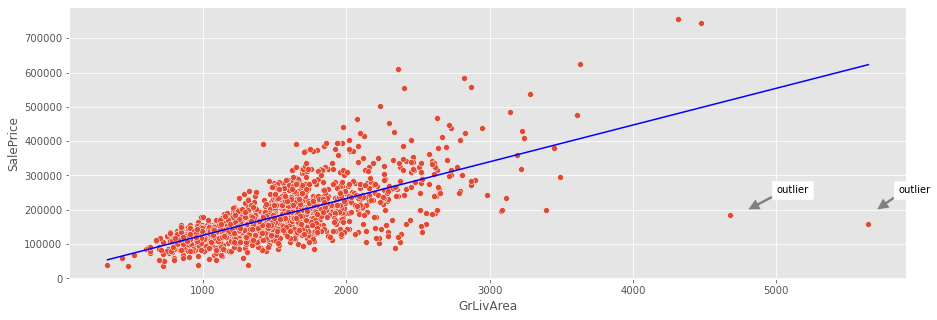

In [21]:
m, b = np.polyfit(df_train['GrLivArea'], df_train[TARGET], 1)

plt.figure(figsize=(15, 5));
sns.scatterplot(data=df_train, x='GrLivArea', y=TARGET)
sns.lineplot(x=df_train['GrLivArea'], y=m*df_train['GrLivArea']+b, color='blue')
plt.annotate("outlier", xy=(4800, 200000), xytext=(5000, 250000), arrowprops={'facecolor':'grey', 'width': 3}, backgroundcolor = 'white')
plt.annotate("outlier", xy=(5700, 200000), xytext=(5850, 250000), arrowprops={'facecolor':'grey', 'width': 3}, backgroundcolor = 'white');

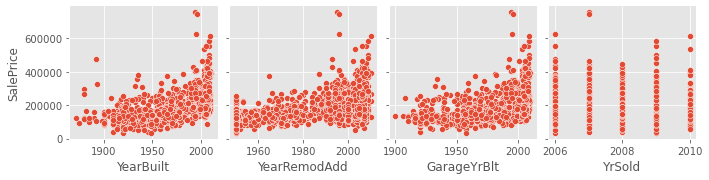

<Figure size 2160x1440 with 0 Axes>

In [22]:
sns.pairplot(data=df_train, y_vars=TARGET, x_vars=time_vars);
plt.figure(figsize=(30,20));

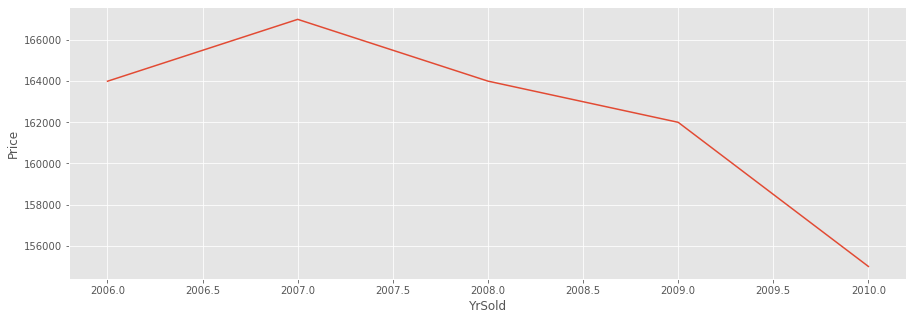

In [23]:
plt.figure(figsize=(15,5));
df_train.groupby('YrSold')[TARGET].median().plot();
plt.ylabel("Price");

There has been a drop in the value of the houses. That is unusual, in real life, house prices typically go up as years go by maybe because 2008 financial crisis.

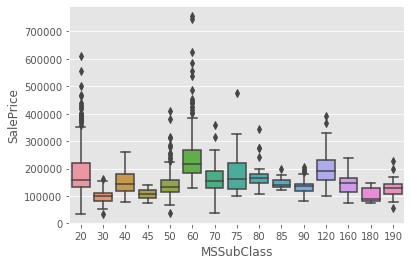

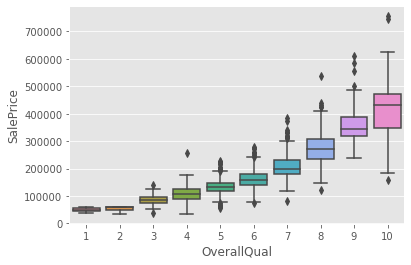

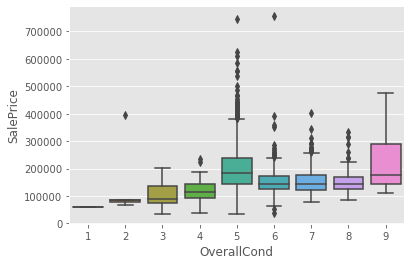

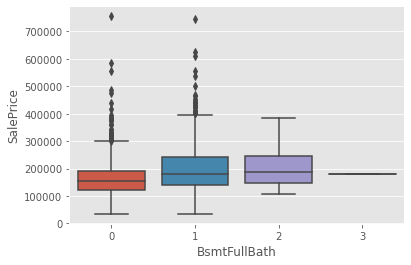

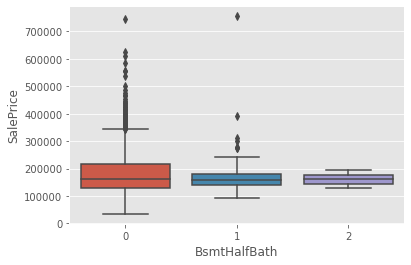

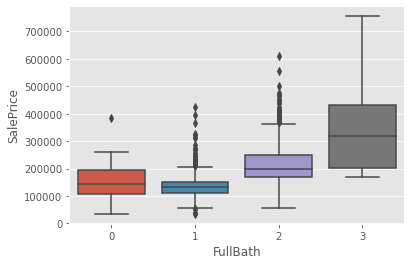

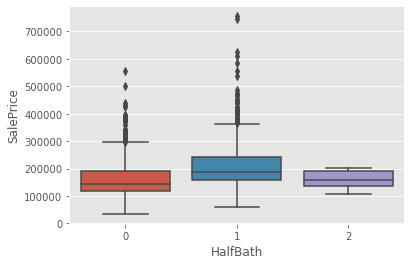

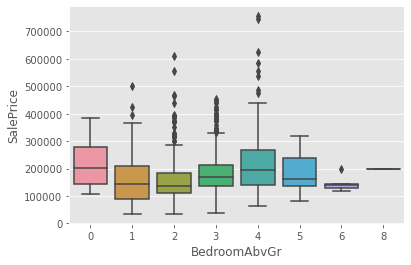

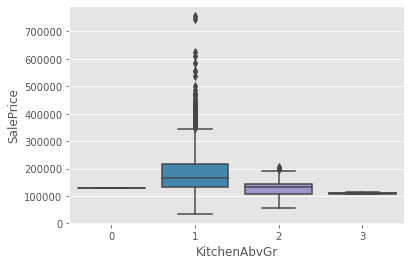

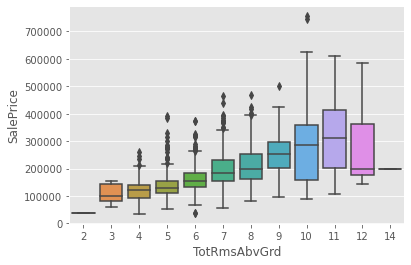

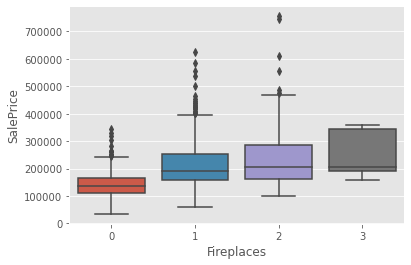

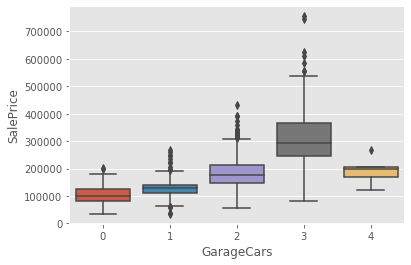

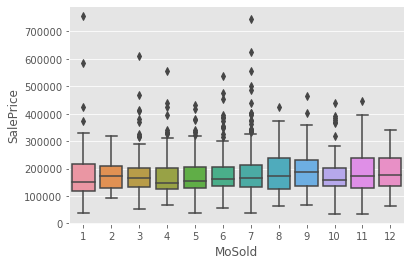

In [24]:
# fig, axes = plt.subplots(1, discrete_vars_num, figsize=(65, 5), sharey=False)
for i, var in enumerate(discrete_vars):
    sns.boxplot(data=df_train, x=var, y=TARGET)
    plt.show();

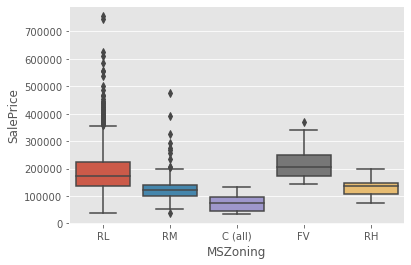

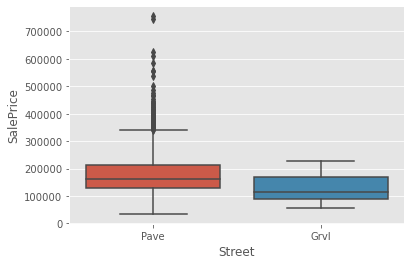

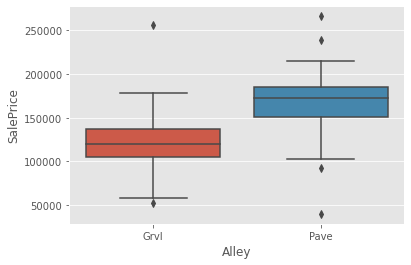

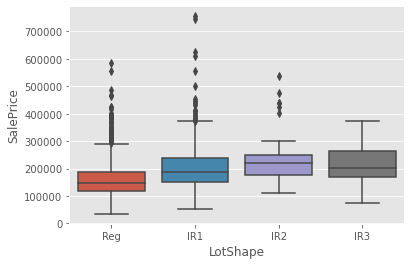

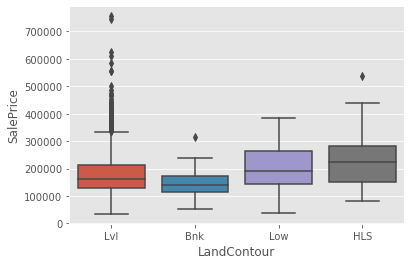

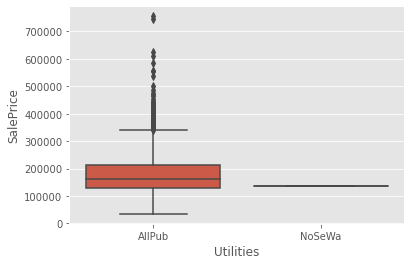

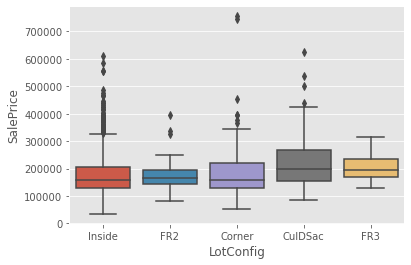

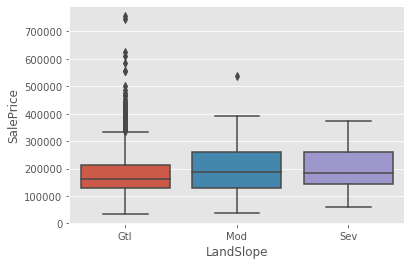

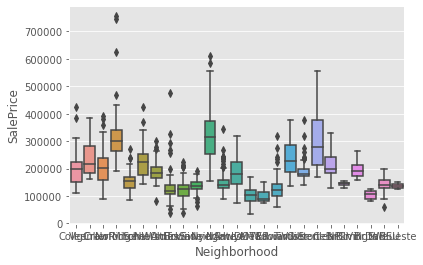

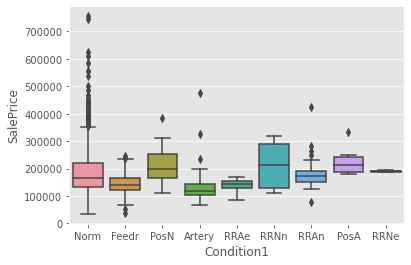

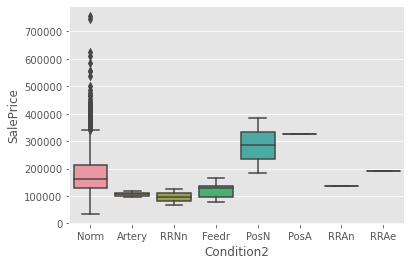

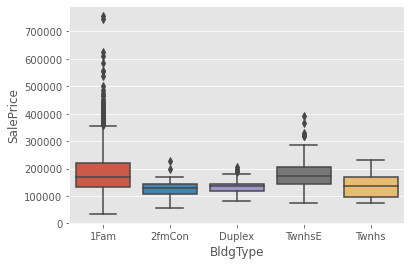

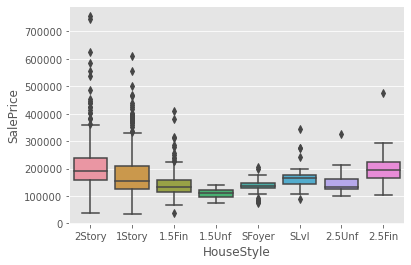

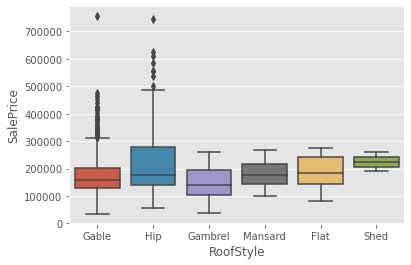

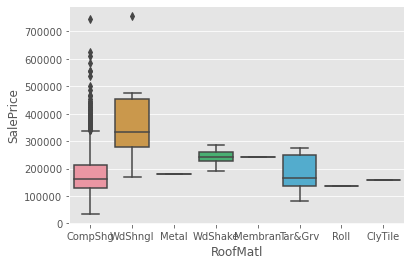

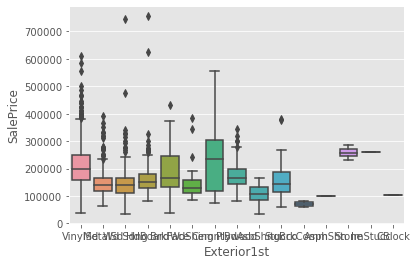

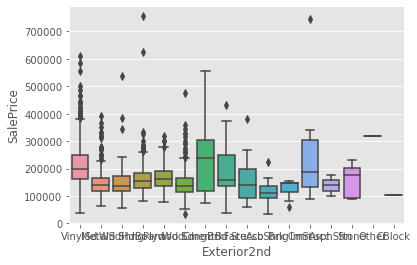

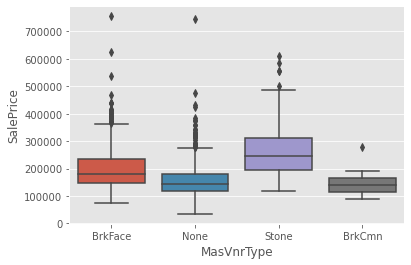

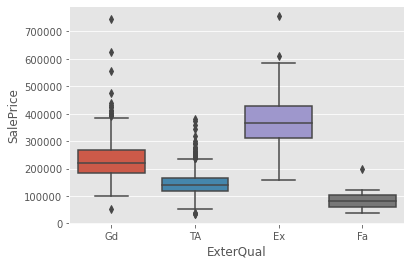

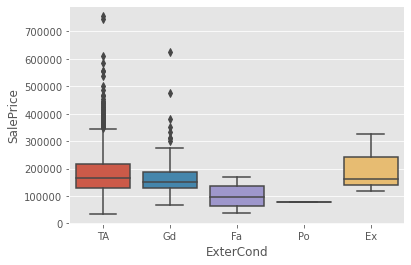

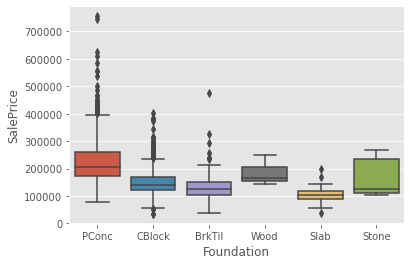

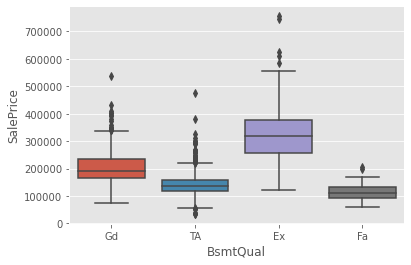

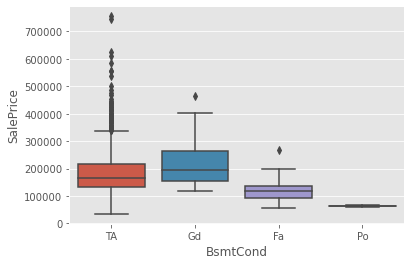

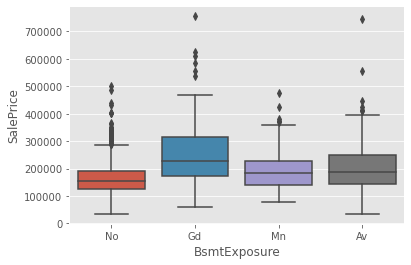

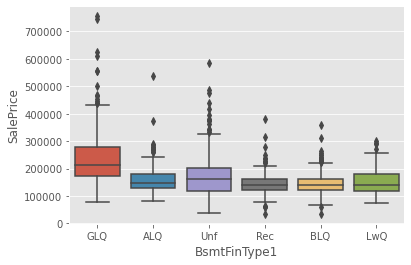

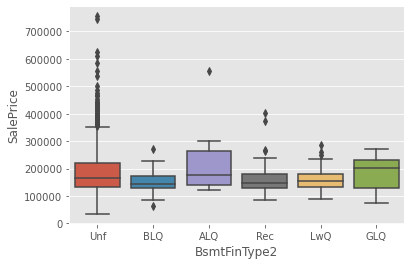

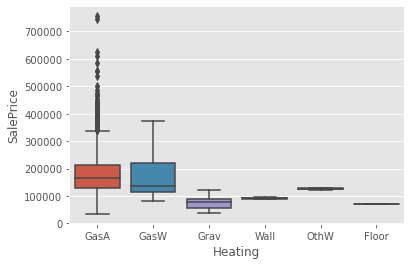

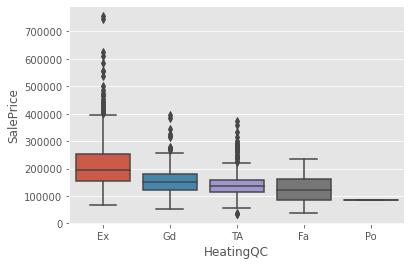

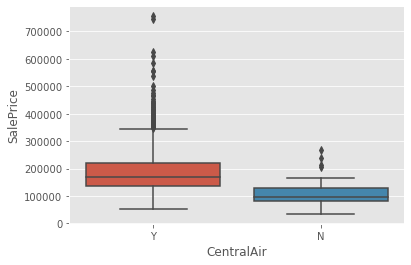

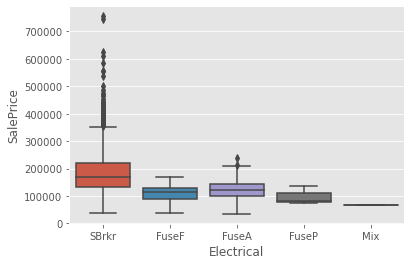

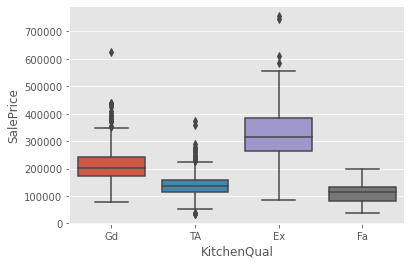

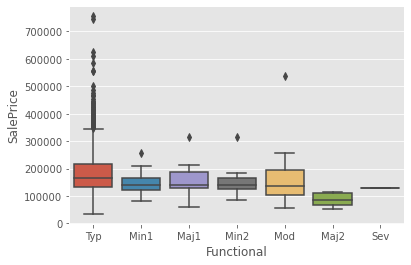

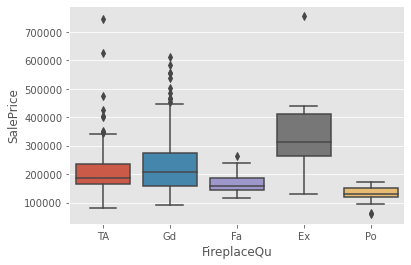

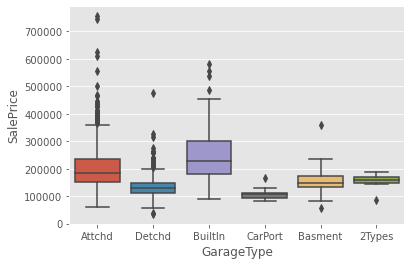

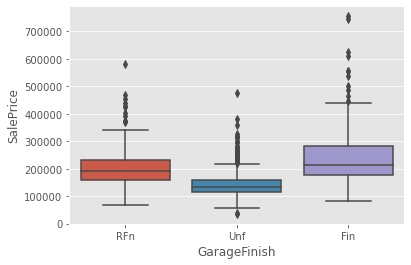

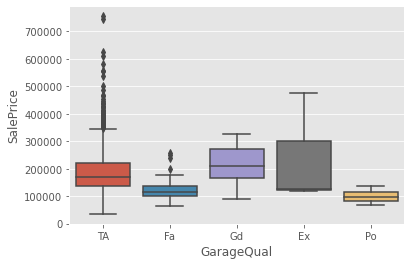

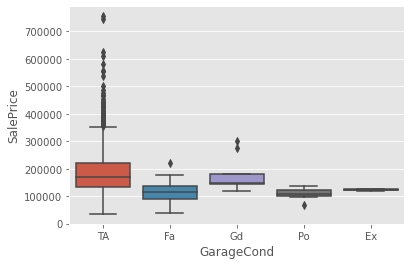

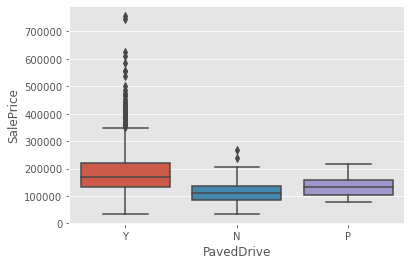

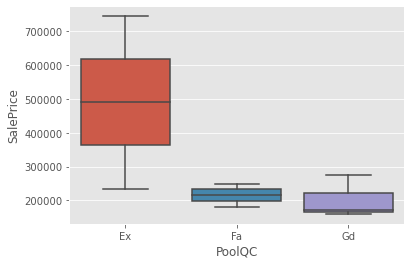

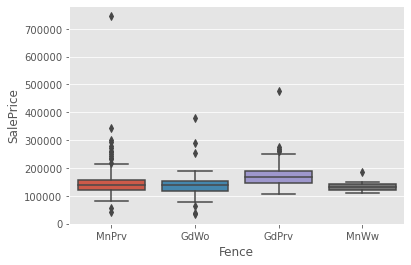

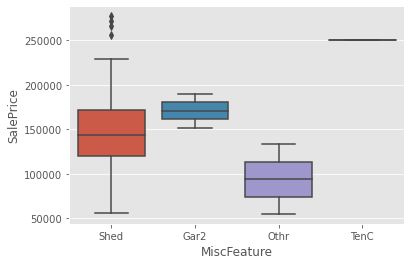

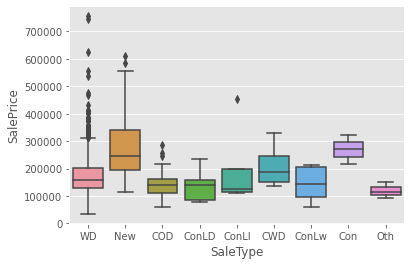

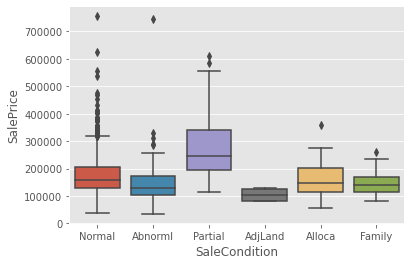

In [25]:
# fig, axes = plt.subplots(1, categorical_variables_num, figsize=(350, 5), sharey=False)
for i, var in enumerate(categorical_variables):
    sns.boxplot(data=df_train, x=var, y=TARGET)
    plt.show();

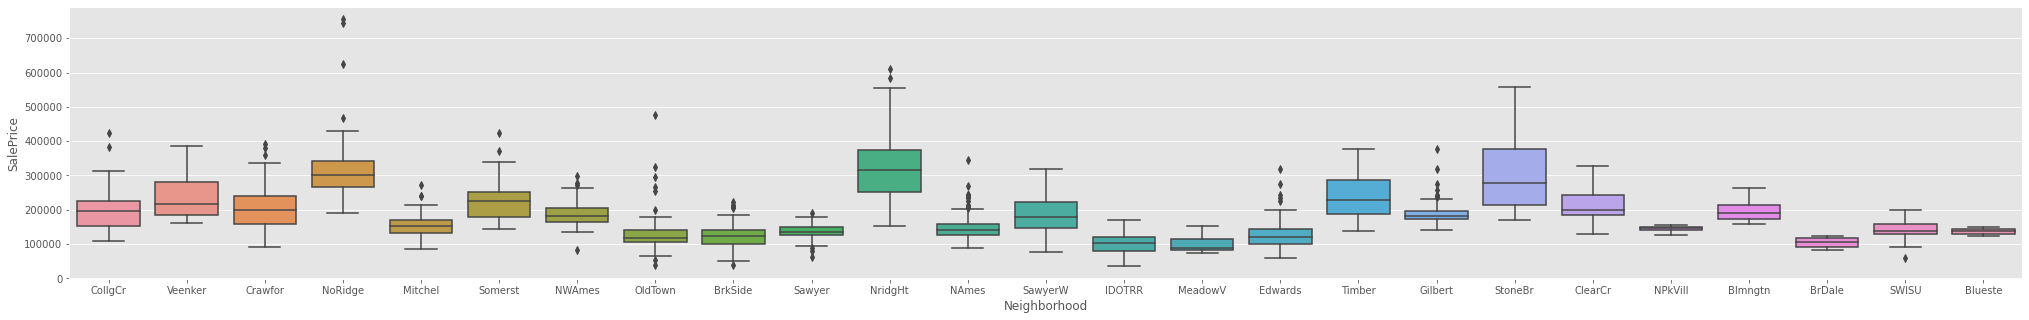

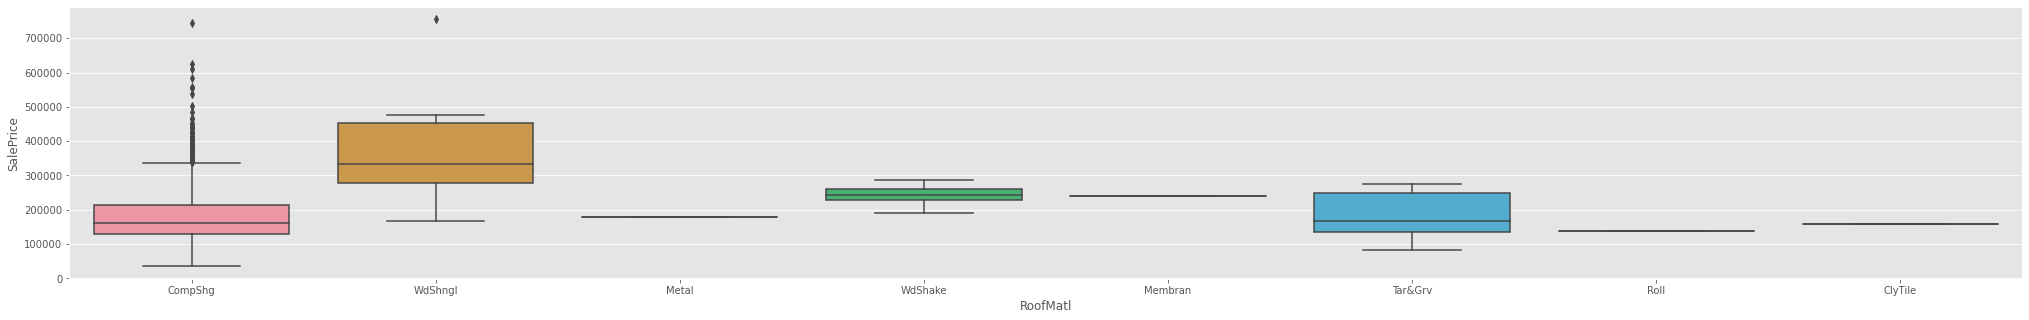

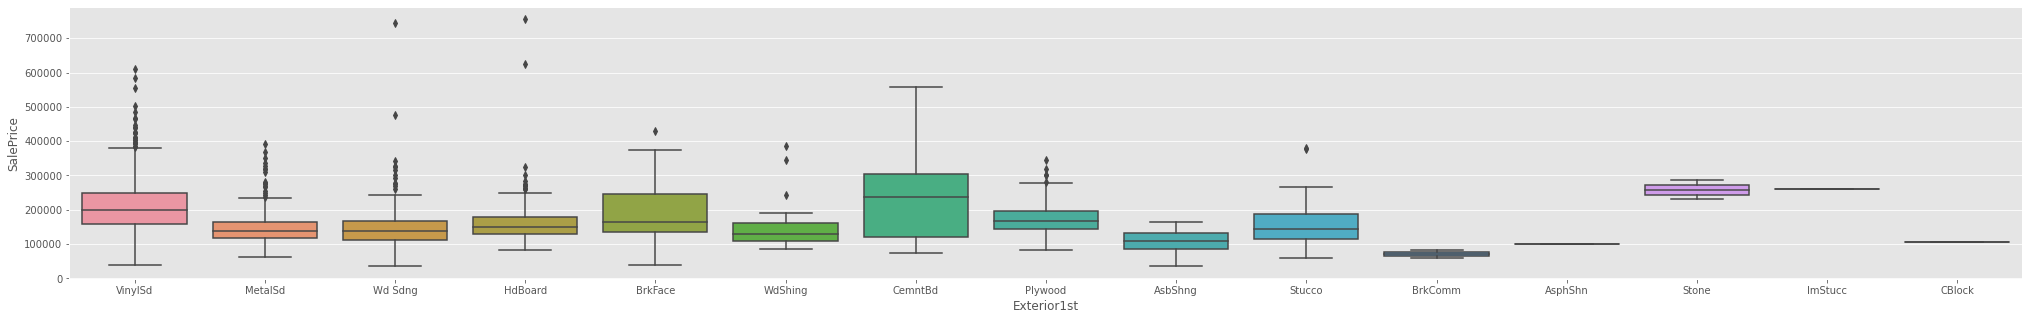

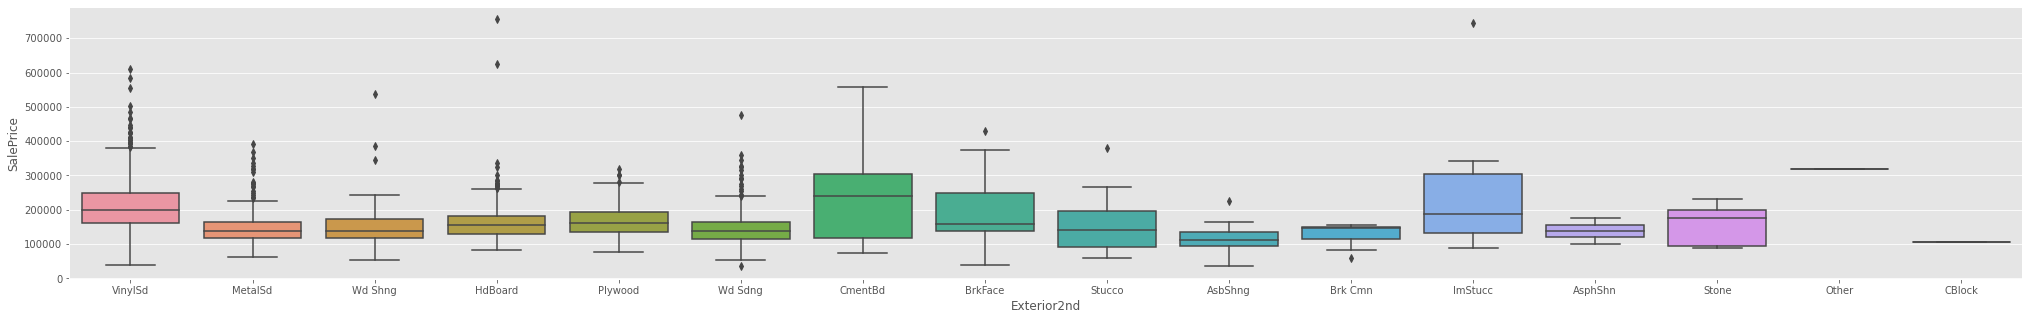

In [26]:
# for better visualisation
need_more_visualisation = ['Neighborhood', 'RoofMatl', 'Exterior1st', 'Exterior2nd']
for var in need_more_visualisation:
    plt.figure(figsize=(35, 5))
    sns.boxplot(data=df_train, x=var, y=TARGET);

### Target vs All Summary

* numerical variables
> * 'GrLivArea' and 'TotalBsmtSF' seem to be linearly related with 'SalePrice' which means that as one variable increases, the other also increases. In the case of 'TotalBsmtSF', the slope towrds y ('SalePrice') is very high.
> * 'OverallQual', 'TotRmsAbvGrd' and 'YearBuilt' also seem to be related with 'SalePrice'. The relationship seems to be stronger in the case of 'OverallQual', where the box plot shows how sales prices increase with the overall quality.
* categorical variables
> * All variables that are ordinals goes towards the main concept of ordinality (e.g. 'PoolQC' (Pool quality) if 'Ex' (Excellent) the 'SalePrice' is higher than 'Gd' (Good)).
> * Other variables depends on its value for example 'CentralAir' if it was 'Y' (yes) the higher the sale price . 

## Correlations

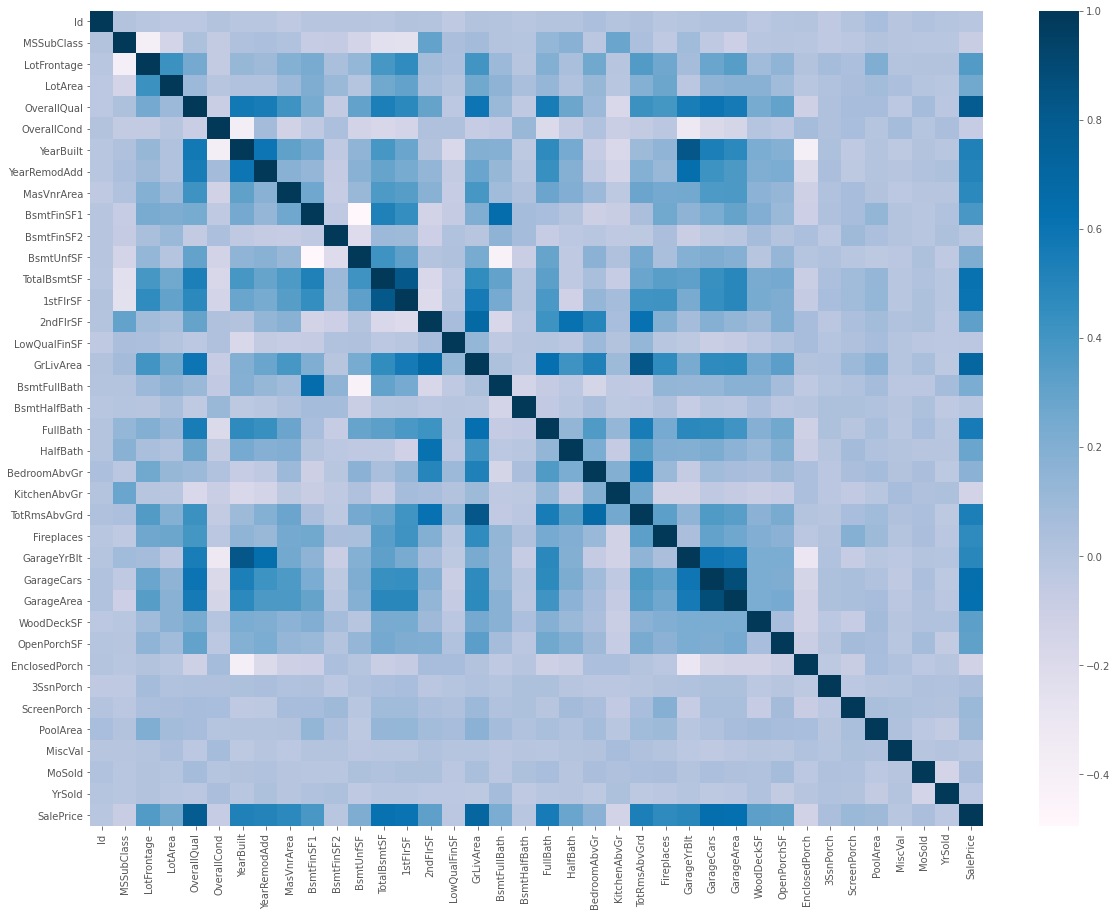

In [27]:
corr_matrix = df_train.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, fmt='.1f', cmap='PuBu');

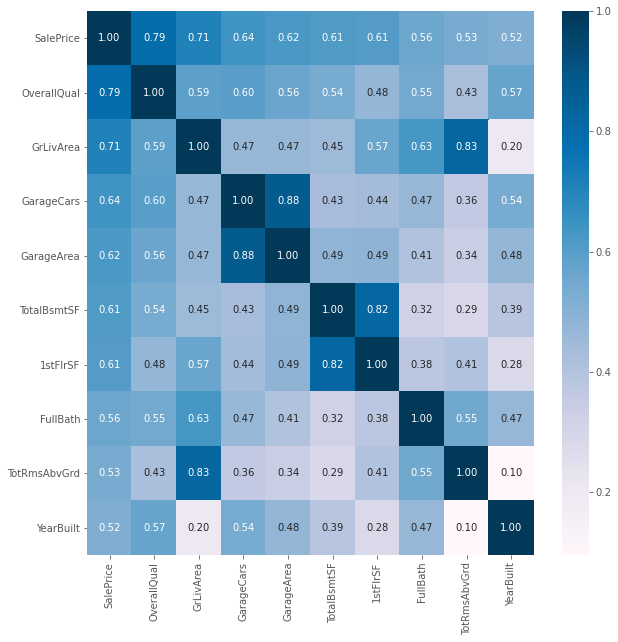

In [28]:
#saleprice correlation matrix
k = 10 
cols = corr_matrix.nlargest(k, TARGET)[TARGET].index
cm = np.corrcoef(df_train[cols].values.T)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, yticklabels=cols.values, xticklabels=cols.values, annot=True, fmt='.2f', cmap='PuBu');

### In Summary

* 'GarageCars' and 'GarageArea' are the same, the number of cars that fit into the garage is a consequence of the garage area they are like twin brothers. Therefore, we just need one of these variables in our analysis (we can keep 'GarageCars' since its correlation with 'SalePrice' is higher).
* 'TotalBsmtSF' and '1stFloor' also the same twin brothers. We can keep 'TotalBsmtSF'.
* 'TotRmsAbvGrd' and 'GrLivArea', twin brothers again. 
* 'YearBuilt' is slightly correlated with 'SalePrice'.